In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 20190327: Import and clean data

In [2]:
# Import data and clean DataFrame
"""
xlsx file from pdftoexcel.com cleaned by converting unicode to strings and removing leading and trailing 
quotes in index labels. Dropped variants 71, 72, and 73 which has M13 mutations

gcamp_muts = pd.read_excel('./GCaMP6_lib.xlsx', index_col = 0)
gcamp_muts['Mutations added to GCaMP3'] = [str(mut) for mut in gcamp_muts['Mutations added to GCaMP3']]
gcamp_muts.index = [var[1:-1] for var in gcamp_muts.index.tolist()]
gcamp_muts.drop(['71', '72', '73'], inplace = True)
gcamp_muts.to_csv('./GCaMP6_lib.csv')

"""

gcamp_muts = pd.read_csv('./GCaMP6_lib.csv', index_col = 0)

# Get sequence for alignments

gcamp3_seq = 'MGSHHHHHHGMASMTGGQQMGRDLYDDDDKDLATMVDSSRRKWNKTGHAVRAIGRLSSLENVYIKADKQKNGIKANFKIRHNIEDGGVQLAYHYQQNTPIGDGPVLLPDNHYLSVQSKLSKDPNEKRDHMVLLEFVTAAGITLGMDELYKGGTGGSMVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYIQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNTRDQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEAELQDMINEVDADGDGTIDFPEFLTMMARKMKDTDSEEEIREAFRVFDKDGNGYISAAELRHVMTNLGEKLTDEEVDEMIREADIDGDGQVNYEEFVQMMTAK*'
# Numbering here is correct, so the number in the mutant name = index - 1

# Get dataframe with only single point mutants
singlePointMuts = []
for mut in gcamp_muts.index.tolist()[2:]:
    mutations = gcamp_muts.loc[mut, 'Mutations added to GCaMP3']
    if ' ' not in mutations:
        singlePointMuts.append(mut)
pointMuts = gcamp_muts.loc[singlePointMuts].copy()

In [10]:
# Generate dataframe of type of mutation by residue number
AA1idx = [
    'A',
    'V',
    'L',
    'I',
    'M',
    'F',
    'Y',
    'W',
    'S',
    'T',
    'N',
    'Q',
    'C',
    'D',
    'E',
    'H',
    'K',
    'R',
    'G',
    'P',
    '*'
]
pmMap = pd.DataFrame(index = AA1idx, columns = range(1, len(gcamp3_seq) + 1))
for var in pointMuts.index.tolist():
    muts = pointMuts.loc[var, 'Mutations added to GCaMP3']
    resn = int(muts[1:-1])
    mut = muts[-1]
    pmMap.loc[mut, resn] = 1
    

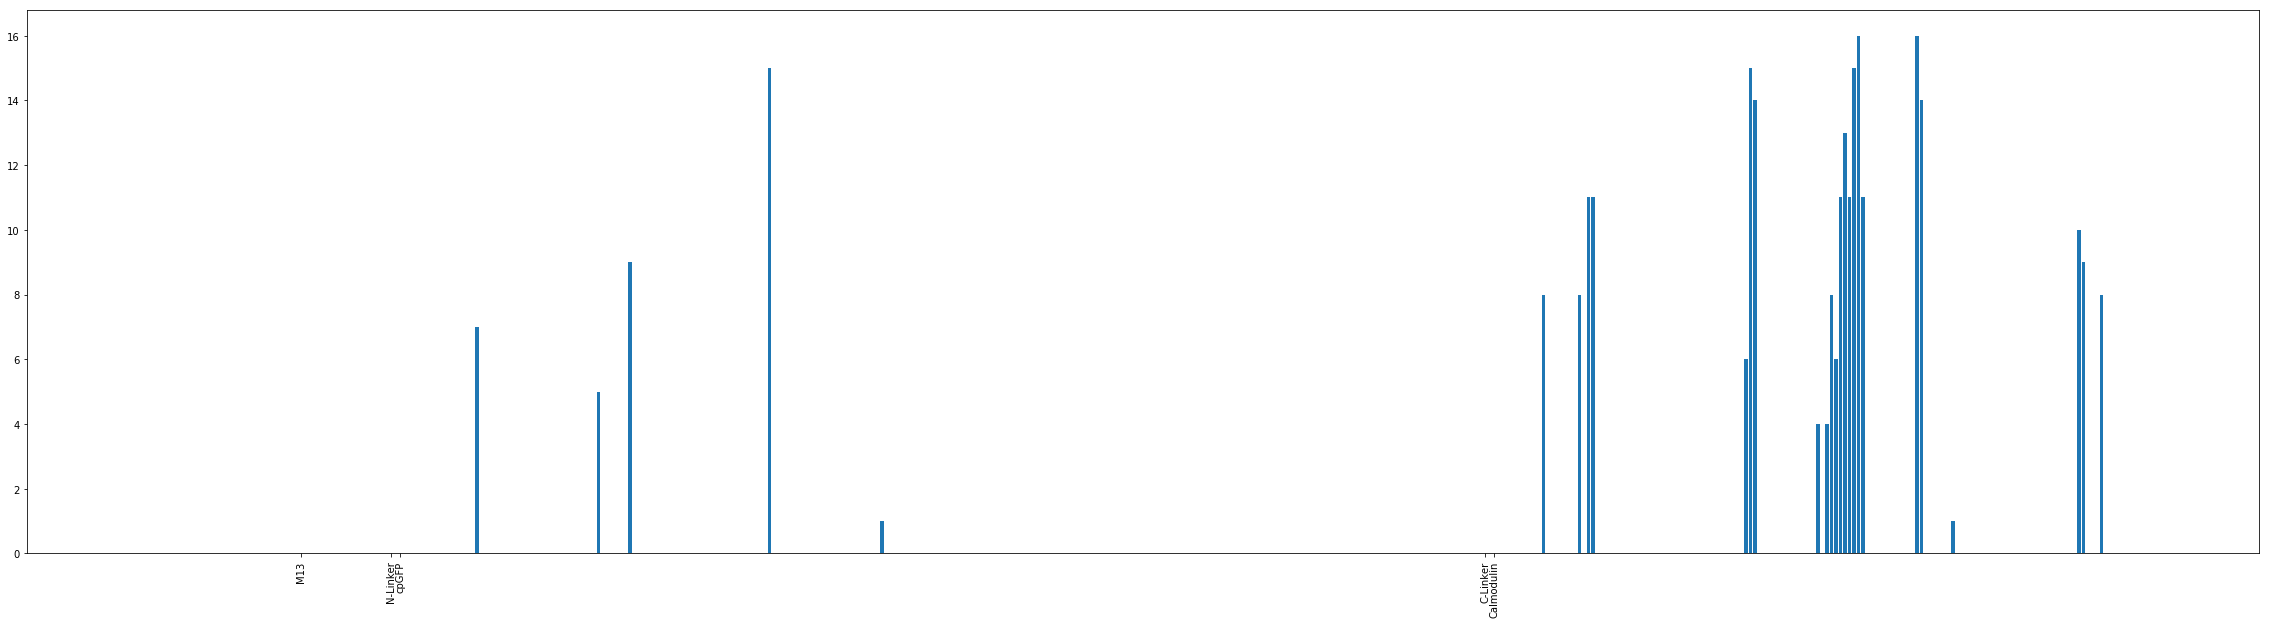

In [33]:
plt.figure(figsize = [40, 10])
plt.bar(x = range(1, len(gcamp3_seq) + 1), height = pmMap.fillna(0.0).sum(axis = 0))
plt.xticks(np.array([39, 59, 61, 302, 304]), ('M13', 'N-Linker', 'cpGFP', 'C-Linker', 'Calmodulin'), rotation = 'vertical')
plt.show()

# Build a Random Forest Model

In [237]:
dat = pd.DataFrame(index = pointMuts.index.tolist(), columns = ['Position', 'Mutation', 'dF/F0'])
for mut in dat.index.tolist():
    dat.loc[mut, 'Position'] = int(pointMuts.loc[mut, 'Mutations added to GCaMP3'][1:-1])
    dat.loc[mut, 'Mutation'] = float(ord(pointMuts.loc[mut, 'Mutations added to GCaMP3'][-1]))
    dat.loc[mut, 'dF/F0'] = pointMuts.loc[mut, '160 AP !F/F0']

In [241]:
# Import train_test_split function
from sklearn.model_selection import train_test_split
x = dat.loc[:, ('Position', 'Mutation')]
y = dat['dF/F0'].values.tolist()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [242]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestRegressor

#Create a Gaussian Classifier
clf = RandomForestRegressor(n_estimators=1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(x_train,y_train)

y_pred=clf.predict(x_test)

In [243]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Explained Variance:",metrics.explained_variance_score(y_test, y_pred))
print("R2 Score",metrics.r2_score(y_test, y_pred))

('Explained Variance:', 0.63385662525157516)
('R2 Score', 0.63123258558361517)


In [244]:
# Figure out feature importance
feature_imp = pd.Series(clf.feature_importances_,index = x.columns.tolist()).sort_values(ascending=False)
feature_imp

Position    0.699787
Mutation    0.300213
dtype: float64

In [245]:
"""# Visualize tree (didn't work)
estimator = clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = x.columns.tolist(),
                class_names = None,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')"""

"# Visualize tree (didn't work)\nestimator = clf.estimators_[5]\n\nfrom sklearn.tree import export_graphviz\n# Export as dot file\nexport_graphviz(estimator, out_file='tree.dot', \n                feature_names = x.columns.tolist(),\n                class_names = None,\n                rounded = True, proportion = False, \n                precision = 2, filled = True)\n\n# Convert to png using system command (requires Graphviz)\nfrom subprocess import call\ncall(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])\n\n# Display in jupyter notebook\nfrom IPython.display import Image\nImage(filename = 'tree.png')"

In [246]:
thresholds = []

thresholds = pd.DataFrame(index = [], columns = ['n_samples'])
test.append(pd.DataFrame(data = 5, index = [373], columns = ['n_samples']))
for estimator in clf.estimators_:
    tree = pd.DataFrame(estimator.tree_.__getstate__()['nodes']).sort_values(by = 'weighted_n_node_samples', ascending = False)[0:4]
    #thresholds.extend(tree['threshold'][0:4].values)
    #threshValues = tree['threshold'][0:4].values
    for node in tree.index.tolist():
        thresh = tree.loc[node, 'threshold']
        count = tree.loc[node, 'n_node_samples']
        if thresh in thresholds.index.tolist():
            thresholds.loc[thresh] = thresholds.loc[thresh] + count
        else:
            thresholds = thresholds.append(pd.DataFrame(data = count, index = [thresh], columns = ['n_samples']))


In [360]:
idx = [(not thresh.is_integer()) for thresh in thresholds.index.tolist()]
positions = thresholds[idx]
positions['Total dFF0'] = 0.0
positions['Count'] = 0
positions['Average'] = np.nan
for pos in positions.index.tolist():
    posInt = str(int(pos))
    idx2 = [(posInt in mut) for mut in pointMuts['Mutations added to GCaMP3']]
    posDF = pointMuts[idx2]
    positions.loc[pos, 'Total dFF0'] = positions.loc[pos, 'Total dFF0'] + posDF['160 AP !F/F0'].sum()
    positions.loc[pos, 'Count'] = positions.loc[pos, 'Count'] + len(posDF)
    
    posInt = str(np.ceil(pos))
    idx2 = [(posInt[:-2] in mut) for mut in pointMuts['Mutations added to GCaMP3']]
    posDF = pointMuts[idx2]
    fluorSum = posDF['160 AP !F/F0'].sum()
    posCount = len(posDF)
    n_samples = positions.loc[pos, 'n_samples']
    newRow = pd.DataFrame(index = [posInt], columns = positions.columns.tolist())
    newRow.loc[posInt] = [n_samples, fluorSum, posCount, np.nan]
    positions = positions.append(newRow)

for pos in positions.index.tolist():
    if positions.loc[pos, 'Count'] != 0:
        positions.loc[pos, 'Average'] = positions.loc[pos, 'Total dFF0'] / positions.loc[pos, 'Count']

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [363]:
positions.sort_values('Average', ascending = False)

,n_samples,Total dFF0,Count,Average
68.5,1854,1.06,1,1.06
81.0,134,11.49,11,1.04455
81.5,2486,11.49,11,1.04455
381.5,26577,11.49,11,1.04455
381.0,7315,11.49,11,1.04455
398.5,17084,13.71,16,0.856875
385.5,18739,13.48,16,0.8425
385.0,424,13.48,16,0.8425
383.0,57,9.04,11,0.821818
83.0,552,9.04,11,0.821818


In [352]:
    newRow = pd.DataFrame(index = [posInt], columns = positions.columns.tolist())
    newRow.loc[posInt] = [n_samples, fluorSum, posCount, np.nan]

In [353]:
newRow


,n_samples,Total dFF0,Count,Average
84.0,67,0,0,NaN
